# CNN modeling


-----

Imports & wandb init

In [ ]:
import wandb
wandb.login()

In [ ]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
from argparse import Namespace
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.models as models
from tqdm import tqdm
import torch.nn.functional as F
import random
import math
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import timm

In [ ]:
TRAIN_DATA_PATH = "trainDataF.csv"
VAL_DATA_PATH = "valDataF.csv"
TEST_DATA_PATH = "testDataF.csv"

# Trainer

Firstly we create out Logger class for collecting stats.

In [ ]:
class Logger:
  def __init__(self):
    self.values = dict()

  # Saves values to dict
  def step(self, key, value):
    sum, count = 0.0, 0.0
    if key in self.values:
      sum, count = self.values[key]
    sum += value
    count += 1.0
    self.values[key] = (sum, count)

  # Used for retrieving values
  def get(self):
    result = dict()
    for k, (sum,count) in self.values.items():
      result[k] = float(sum/count)
    return result

Now we create our Trainer class which is used for training, validating and testing.

In [ ]:
# Method responsible for training, validating, testing model
class Trainer:
    def __init__(self, cfg, model):
        self.run = wandb.init()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if possible
        self.cfg = cfg
        self.model = model.to(self.device)

        # Initialization of the optimizer based on the given config
        if cfg.opt == "adam":
            self.opt = torch.optim.Adam(
                params=self.model.parameters(),
                lr=cfg.learning_rate,
                betas=cfg.betas
            )
        elif cfg.opt == "sgd":
            self.opt = torch.optim.SGD(
                params=self.model.parameters(),
                lr=cfg.learning_rate,
                momentum=cfg.momentum
            )
        elif cfg.opt == "rmsp":
            self.opt = torch.optim.RMSprop(
                params=self.model.parameters(),
                lr=cfg.learning_rate,
                alpha=cfg.alpha
            )

    # Our own RMSE loss function
    def partialRMSELoss(self, y_true, y_pred):
        x = self.partialMSELoss(y_true, y_pred)

        x = torch.sqrt(x)

        return x

    # Our own MSE loss function
    def partialMSELoss(self, y_true, y_pred):
        mask = ~torch.isnan(y_true)  # Mask for non-null values

        return F.mse_loss(y_pred[mask], y_true[mask])

    # Our own MAE loss function
    def partialMAELoss(self, y_true, y_pred):
        mask = ~torch.isnan(y_true)  # Mask for non-null values

        return F.l1_loss(y_pred[mask], y_true[mask])

    # Sets-up dataloader which will feed batches to the model during training, validating and testing
    def setup(self, datamodule):
        self.datamodule = datamodule
        self.datamodule.setup(self.cfg)

    # Saves epoch as checkpoint to a directory from config
    def save_epoch(self, model, epoch):
      dir = self.cfg.checkpoint_dir

      if not os.path.exists(dir):
        os.makedirs(dir)

      epoch_path = os.path.join(dir, f"epoch_{epoch}.pt")
      torch.save(model, epoch_path)


    # Trains the model and calculates metrics
    def train_epoch(self, epoch, model, dataloader, stats):
        with tqdm(dataloader, desc=f"Train: {epoch}") as progress:
            for x,y in progress:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat_logits = model(x)
                l = self.partialMSELoss(y, y_hat_logits)
                # Backward pass & Update params
                self.opt.zero_grad()
                l.backward()
                self.opt.step()

                # Metrics
                mae = self.partialMAELoss(y, y_hat_logits)
                rmse = self.partialRMSELoss(y, y_hat_logits)

                # Update statistics
                stats.step("loss_train", l.item())
                stats.step("mae_train", mae.item())
                stats.step("rmse_train", rmse.item())
                progress.set_postfix(stats.get())

        # Save checkpoint
        self.save_epoch(self.model, epoch)


    # Validates the epoch and calculates metrics for it
    def validate_epoch(self, epoch, model, dataloader, stats):
        with torch.no_grad():       # We don't need gradients in validation
            with tqdm(dataloader, desc=f"Val: {epoch}") as progress:
                for x,y in progress:
                    x = x.to(self.device)
                    y = y.to(self.device)

                    # Forward pass
                    y_hat_logits = model(x)

                    l = self.partialMSELoss(y, y_hat_logits)

                    # Metrics
                    mae = self.partialMAELoss(y, y_hat_logits)
                    rmse = self.partialRMSELoss(y, y_hat_logits)

                    # Update statistics
                    stats.step("loss_val", l.item())
                    stats.step("mae_val", mae.item())
                    stats.step("rmse_val", rmse.item())
                    progress.set_postfix(stats.get())

            #self.run.log({"Metrics Validation": stats.get()})


    def fit(self):
        for epoch in range(self.cfg.max_epochs):

            # Training phase
            stats_train = Logger()
            self.train_epoch(
                epoch,
                model=self.model,
                dataloader=self.datamodule.dataloader_train,
                stats=stats_train
            )

            # Validation phase
            stats_val = Logger()
            self.validate_epoch(
                epoch,
                model=self.model,
                dataloader=self.datamodule.dataloader_val,
                stats=stats_val
            )

            self.run.log({"train": stats_train.get(), "val": stats_val.get()})

    # Tests the latest model on testing dataset
    def test_model(self, model, dataloader, stats):
            with torch.no_grad():       # We don't need gradients in validation
                with tqdm(dataloader, desc=f"Test: ") as progress:
                    for x,y in progress:
                        x = x.to(self.device)
                        y = y.to(self.device)

                        # Forward pass
                        y_hat_logits = model(x)

                        # Metrics
                        mse = self.partialMSELoss(y, y_hat_logits)
                        mae = self.partialMAELoss(y, y_hat_logits)
                        rmse = self.partialRMSELoss(y, y_hat_logits)

                        # Update statistics
                        stats.step("test_mse", mse.item())
                        stats.step("test_mae", mae.item())
                        stats.step("test_rmse", rmse.item())
                        progress.set_postfix(stats.get())

                    #self.run.log({"Metrics": stats.get()})
                    test_metrics_table = wandb.Table(
                        data=[
                            ["Test MAE", stats.get()["test_mae"]],
                            ["Test MSE", stats.get()["test_mse"]],
                            ["Test RMSE", stats.get()["test_rmse"]],
                        ],
                        columns=["Metric", "Value"]
                    )
                    self.run.log({"Test Metrics": test_metrics_table})

    def test(self):
        stats_test = Logger()
        self.test_model(
            model=self.model,
            dataloader=self.datamodule.dataloader_test,
            stats=stats_test
        )

    def print_model_summary(self):
      summary(self.model, (1, 96, 960), cfg.batch_size)

# Dataset class


We created a custom class for our dataset, where we load the needed data and also randomly apply augmentations. The augmentations are randomly chosen from Gaussian Blur, Rotation and Brightness adjusting.

In [ ]:
# Sets-up dataset class for our dataset
class FacialKeypointDataset(torch.utils.data.Dataset):
    # Reads dataset and spits into features and targets
    def __init__(self, data, augmentation_prob):
      self.data = pd.read_csv(data)
      self.keypoints = self.data.drop(columns=["Image"])
      self.images = self.data["Image"].apply(lambda x: np.array(x.split(), dtype=np.uint8))
      self.images = self.images.apply(lambda x: x.reshape(96, 96))
      self.augmentation_probability = augmentation_prob
      self.transform = transforms.Compose([
            transforms.ToTensor()
        ])


    def __len__(self):
      return len(self.images)

    # Calculates the new keypoints if the image is rotated on y-axis
    def flip_keypoints(self, keypoints):
      keypoints[::2] = 96.0 - keypoints[::2]

      return keypoints


    # Returns specific record on idx
    def __getitem__(self, idx):
      keypoints = self.keypoints.iloc[idx].values
      keypoints = torch.tensor(keypoints, dtype=torch.float32)

      image = self.images.iloc[idx]
      image = Image.fromarray(image)
      image = self.transform(image)

      # Random augmentations (blur, brightness, rotation)
      if random.random() <= self.augmentation_probability:
        choice = random.randint(1,3)
        if choice == 1: # Blur
          image = v2.GaussianBlur((5, 5), (0.1, 2.0))(image)
        elif choice == 2: # Brightness
          image = transforms.functional.adjust_brightness(image, random.uniform(0.8, 1.2))
        elif choice == 3: # Rotation
          angle = random.randint(-20, 20)
          image = transforms.functional.rotate(image, angle=angle)
          angle = -angle
          angle_radians = math.radians(angle)
          x = (keypoints[::2] - 48) * math.cos(angle_radians) - (keypoints[1::2] - 48) * math.sin(angle_radians)
          y = (keypoints[::2] - 48) * math.sin(angle_radians) + (keypoints[1::2] - 48) * math.cos(angle_radians)
          keypoints[::2] = x + 48
          keypoints[1::2] = y + 48


      return image, keypoints

In [ ]:
# This class initializes dataloaders, which manage their splitting into batches
class DataModule:
    def __init__(self):

      # Training dataset
      self.dataset_train = FacialKeypointDataset(
          data = TRAIN_DATA_PATH,
          augmentation_prob = 0.3
      )

      # Validation dataset
      self.dataset_val = FacialKeypointDataset(
          data = VAL_DATA_PATH,
          augmentation_prob = -1
      )

      # Testing dataset
      self.dataset_test = FacialKeypointDataset(
          data = TEST_DATA_PATH,
          augmentation_prob = -1
      )


    def setup(self, cfg):
      # Traning dataset data loader
      self.dataloader_train = torch.utils.data.dataloader.DataLoader(
          self.dataset_train,
          batch_size = cfg.batch_size,
          shuffle = True,
          num_workers=cfg.num_workers
      )

      # Validation dataset data loader
      self.dataloader_val = torch.utils.data.dataloader.DataLoader(
          self.dataset_val,
          batch_size = cfg.batch_size,
          shuffle = True,
          num_workers=cfg.num_workers
      )

      # Testing dataset data loader
      self.dataloader_test = torch.utils.data.dataloader.DataLoader(
          self.dataset_test,
          batch_size = cfg.batch_size,
          shuffle = True,
          num_workers=cfg.num_workers
      )

---
## Models classes


Now we can finally move on to the modelling phase where we create our own CNN model and configuration.

In [ ]:
class CNN(nn.Module):
    def __init__(self, chin, channels, n_hidden, n_out):
        super().__init__()

        # Model architecture
        self.feature_extractor = nn.Sequential(

            nn.Conv2d(chin, channels, 5, 1, 2),
            nn.BatchNorm2d(channels),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),

            nn.Conv2d(channels, channels*2, 3, 1),
            nn.BatchNorm2d(channels*2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),

            nn.Conv2d(channels*2, channels*4, 3, 1),
            nn.BatchNorm2d(channels*4),
            nn.ReLU(),

            nn.Conv2d(channels*4, channels*8, 3, 2),
            nn.BatchNorm2d(channels*8),
            nn.ReLU(),

        )

        num_features = channels * 8

        # Define fully connected layers
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_features, n_hidden),
            nn.Dropout(0.3),
            nn.Linear(n_hidden, n_out)
        )

    def forward(self, x):
      f = self.feature_extractor(x)
      logits = self.head(f)
      return logits

In [ ]:
cfg = Namespace(
  # Checkpoint directory
  checkpoint_dir = "./experiment3",

  # Data loader
  batch_size = 256,
  num_workers = 2,

  # Training parameters
  opt = "adam",
  betas = (0.9, 0.999),
  momentum = 0.0,
  alpha = 0.99,
  max_epochs = 100,
  learning_rate = 0.001,
)

In [ ]:
test = CNN(1,32,512,30)
trainer = Trainer(cfg, test)
trainer.setup(DataModule())
trainer.fit()

We can use the following function to print details about the last used model.

In [ ]:
# Prints model layers and parameters
trainer.print_model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [256, 32, 96, 960]             832
       BatchNorm2d-2         [256, 32, 96, 960]              64
              ReLU-3         [256, 32, 96, 960]               0
         MaxPool2d-4         [256, 32, 48, 480]               0
            Conv2d-5         [256, 64, 46, 478]          18,496
       BatchNorm2d-6         [256, 64, 46, 478]             128
              ReLU-7         [256, 64, 46, 478]               0
         MaxPool2d-8         [256, 64, 23, 239]               0
            Conv2d-9        [256, 128, 21, 237]          73,856
      BatchNorm2d-10        [256, 128, 21, 237]             256
             ReLU-11        [256, 128, 21, 237]               0
           Conv2d-12        [256, 256, 10, 118]         295,168
      BatchNorm2d-13        [256, 256, 10, 118]             512
             ReLU-14        [256, 256, 

After the training is done we test the model on the testing dataset subset.

In [ ]:
# Tests the model on testing dataset
trainer.test()

Test: 100%|██████████| 5/5 [00:00<00:00,  6.21it/s, test_mse=16.5, test_mae=2.88, test_rmse=4.05]


We can also do the testing on a specific epoch as all of them are saved in one directory.

In [ ]:
model_test = torch.load("experiment3/epoch_99.pt")

In [ ]:
trainer.model = model_test
trainer.test()

Test: 100%|██████████| 5/5 [00:00<00:00,  6.59it/s, test_mse=17.2, test_mae=2.94, test_rmse=4.14]


Now that everything is done we can try to visualize the predicted keypoints. We first load the testing dataset and use the model loaded above. We edit the data a bit, run the loaded model over the data nd plot the results.

## Visualizing the results

In [ ]:
test_images_data = pd.read_csv("testDataF.csv")
test_images = test_images_data["Image"]
test_images

0       131 129 128 122 119 119 120 120 119 119 119 11...
1       39 39 34 31 29 32 31 34 33 33 37 42 52 61 63 6...
2       79 75 74 67 58 57 36 9 0 0 1 1 0 0 0 0 1 0 1 2...
3       57 57 59 60 65 68 68 63 62 66 98 149 181 188 1...
4       232 232 232 232 232 231 231 230 230 230 230 23...
                              ...                        
1053    47 17 14 15 14 17 12 10 9 14 20 9 10 13 18 12 ...
1054    193 183 181 189 142 69 14 7 15 10 6 8 9 9 15 3...
1055    93 80 103 90 103 108 83 111 140 156 146 106 81...
1056    95 96 97 99 99 100 85 65 45 20 2 4 5 13 22 21 ...
1057    198 195 186 177 167 157 146 132 122 120 118 12...
Name: Image, Length: 1058, dtype: object

In [ ]:
test_images_data['numpy_vector'] = test_images_data['Image'].apply(lambda image: np.array([int(pixel) for pixel in image.split()]).reshape(96, 96).astype(np.float32))

In [ ]:
test_images = test_images_data['numpy_vector'] / 255
test_images

0       [[0.5137255, 0.5058824, 0.5019608, 0.47843137,...
1       [[0.15294118, 0.15294118, 0.13333334, 0.121568...
2       [[0.30980393, 0.29411766, 0.2901961, 0.2627451...
3       [[0.22352941, 0.22352941, 0.23137255, 0.235294...
4       [[0.9098039, 0.9098039, 0.9098039, 0.9098039, ...
                              ...                        
1053    [[0.18431373, 0.06666667, 0.05490196, 0.058823...
1054    [[0.75686276, 0.7176471, 0.70980394, 0.7411765...
1055    [[0.3647059, 0.3137255, 0.40392157, 0.3529412,...
1056    [[0.37254903, 0.3764706, 0.38039216, 0.3882353...
1057    [[0.7764706, 0.7647059, 0.7294118, 0.69411767,...
Name: numpy_vector, Length: 1058, dtype: object

In [ ]:
tensor_list = [torch.tensor(arr, dtype=torch.float32).unsqueeze(0) for arr in test_images]

batch_tensor = torch.cat(tensor_list, dim=0)

batch_tensor = batch_tensor.unsqueeze(1)

In [ ]:
model_test.eval()
model_test_cpu = model_test.cpu()
results = model_test_cpu(batch_tensor)

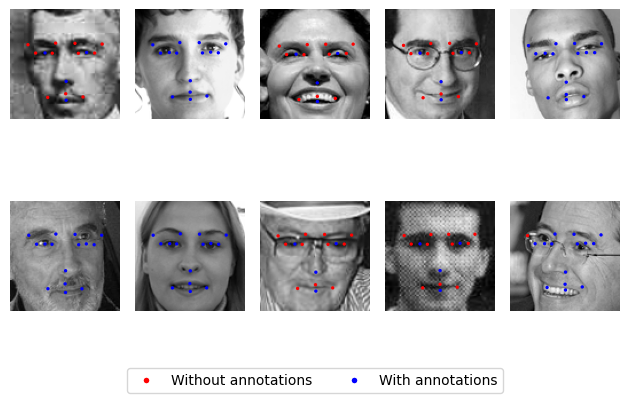

In [ ]:
fig, ax = plt.subplots(2, 5)
for i in range(10):
    colors = [x for x in test_images_data.drop(columns = ["Image", "numpy_vector"]).iloc[i]]
    colors = ["blue" if not np.isnan(x) else "red" for x in colors][::2]
    image = test_images[i]
    ax[i // 5, i % 5].imshow(image, cmap='gray')
    x_coords = [results[i][::2].detach().cpu().numpy()]
    y_coords = [results[i][1::2].detach().cpu().numpy()]
    ax[i // 5, i % 5].scatter(x_coords, y_coords, c=colors, marker='o', s=2)
    ax[i // 5, i % 5].axis('off')

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='Without annotations'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='With annotations')]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=2)
plt.tight_layout()
plt.show()

Above you can see a plot containing 10 images. Each has a set of blue and red keypoints, where the blue keypoints represent predicted keypoints which originally had an annotation in the original dataset and the red keypoints are predicted without annotations.

# EfficientNet

After training our own model we need to compare it with another existing model. For this we chose a pre-trained EfficientNetV2 which is prvided by the timm library.

In [ ]:
class CNN_EfficientNet(nn.Module):
    def __init__(self, chin, channels, n_hidden, n_out):
        super().__init__()
        self.efficientnet = timm.create_model("efficientnetv2_rw_m", pretrained=True)
        self.efficientnet.reset_classifier(0, "")

        self.efficientnet.conv_stem = nn.Conv2d(chin, channels, kernel_size=5, stride=2, padding=1, bias=False)

        for param in self.efficientnet.parameters():
          param.requires_grad = False

        num_features = self.efficientnet.num_features

        # Define fully connected layers
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_features, n_hidden),
            nn.Dropout(0.3),
            nn.Linear(n_hidden, n_out)
        )

    def forward(self, x):
      f = self.efficientnet(x)
      logits = self.head(f)
      return logits


In [ ]:
test = CNN_EfficientNet(1,32,512,30)
trainer_eff = Trainer(cfg, test)
trainer_eff.setup(DataModule())
trainer_eff.fit()

Once again we can print the model architecture and test the model on testing subset.

In [ ]:
trainer_eff.print_model_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [256, 32, 47, 479]             800
          Identity-2         [256, 32, 47, 479]               0
              SiLU-3         [256, 32, 47, 479]               0
    BatchNormAct2d-4         [256, 32, 47, 479]              64
            Conv2d-5         [256, 32, 47, 479]           9,216
          Identity-6         [256, 32, 47, 479]               0
              SiLU-7         [256, 32, 47, 479]               0
    BatchNormAct2d-8         [256, 32, 47, 479]              64
          Identity-9         [256, 32, 47, 479]               0
           Conv2d-10         [256, 32, 47, 479]           1,024
         Identity-11         [256, 32, 47, 479]               0
         Identity-12         [256, 32, 47, 479]               0
   BatchNormAct2d-13         [256, 32, 47, 479]              64
         Identity-14         [256, 32, 

In [ ]:
trainer_eff.test()

Test: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s, test_mse=22, test_mae=3.31, test_rmse=4.66]
